<a href="https://colab.research.google.com/github/subro12/FacebookFriendRecommendation/blob/main/S_FB_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [67]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pylab as plt

%matplotlib inline

import seaborn as sns
from collections import Counter
import csv
import random
import pickle
from sklearn.model_selection import train_test_split
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My\ Drive/Case_studies/Facebook/Facebook/data/

/content/drive/.shortcut-targets-by-id/1c50Q5RcmdpMYj1jCPc3ShOE2y4G8G2ez/Facebook/data


In [4]:
!ls

after_eda  fea_sample  test_y.csv  train.csv  train_y.csv


In [5]:
traincsv = pd.read_csv('train.csv')

In [6]:
traincsv.shape,traincsv.columns

((9437519, 2), Index(['source_node', 'destination_node'], dtype='object'))

In [7]:
traincsv.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [8]:
traincsv[traincsv.isnull().any(1)]
# no nulls in the dataset

,source_node,destination_node


In [9]:
traincsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB


In [10]:
print("Number of duplicated entris are -->",sum(traincsv.duplicated()))
# There are no duplicates in the dataset

Number of duplicated entris are --> 0


In [11]:
g=nx.read_edgelist('after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph,nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


<pre>
Observations
1. we have around 1.8M nodes with edges of 9M.
2. Average in degree is 5.0679 and outdegree is 5.0679
3. Surprisingly Avg in degree and out degree are same.
</pre>

Lets draw a subgraph and visalize how it looks

In [12]:
!ls 

after_eda  fea_sample  test_y.csv  train.csv  train_y.csv


In [13]:
# you can draw subgraph using below lines of code.
# pos = nx.spring_layout(g)
# nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
# plt.savefig("graph_sample.pdf")
# print(nx.info(subgraph))

In [14]:
print("Number of nodes are {}".format(len(g.nodes)))

Number of nodes are 1862220


##### 1.1 number of followers for each user
<pre> lets do eda on followers, how the trend look like </pre>

In [15]:
test =dict(g.in_degree())

In [16]:
# dict(g.in_degree) returns number of followes in a dictionary, where key represents each user, values represent number of followers.
# So, indgree_list a list, which contains the number of followers for each user, length of indegree_list is equal to the number of nodes in graph
indegree_list = list(dict(g.in_degree()).values())

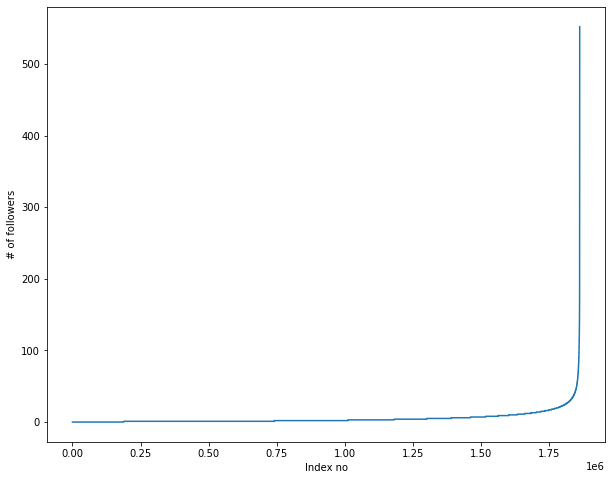

In [17]:
indegree_list.sort()
plt.figure(figsize=(10,8))
plt.plot(indegree_list)
plt.xlabel('Index no')
plt.ylabel('# of followers')
plt.show()

<pre>
Observations:
1. Most of the people has very less followers.
2. very few people has more than 100(around) followers.
3. Maximum number of followers for a user is not less 600.
4. we can zoom in left part of graph observe carefully, similarly for right graph as well.
5. we did see that till the index number 1.50x1e6 not many followers lets zoom in that part first.
</pre>

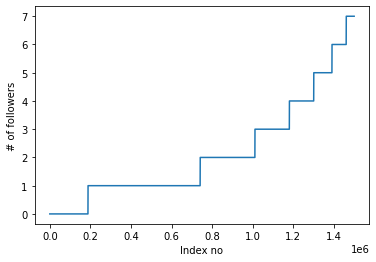

In [18]:
plt.plot(indegree_list[:1500000])
# plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Index no')
plt.ylabel('# of followers')
plt.show()

<pre>
Observations:
1. Out of 1.8M, around 1.5M nodes have followers less than 7 people. 
2. we would see step graph, as there wont be any decimal graphs here.
</pre>

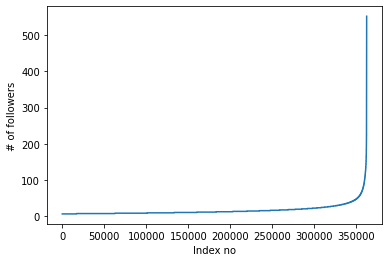

In [19]:
plt.plot(indegree_list[1500000:])
# plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Index no')
plt.ylabel('# of followers')
plt.show()
# we are getting right information with this, lets see percentiles

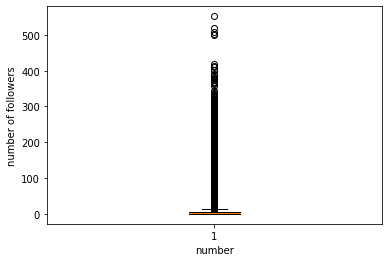

In [20]:
plt.boxplot(indegree_list)
plt.ylabel("number of followers")
plt.xlabel("number")
plt.show()
# This look like many outliers, and make sense, we we see skewed graph.

In [21]:
# lets see percentiles
for i in range(0,11):
  print(90+i,'percentile value is ',np.percentile(indegree_list,90+i))

# looks like, 99 percentile is 40 and 100th percentile is 552, lets zoom in 99 till 100

90 percentile value is  12.0
91 percentile value is  13.0
92 percentile value is  14.0
93 percentile value is  15.0
94 percentile value is  17.0
95 percentile value is  19.0
96 percentile value is  21.0
97 percentile value is  24.0
98 percentile value is  29.0
99 percentile value is  40.0
100 percentile value is  552.0


In [22]:
for i in range(1,11):
  print(99+(i/10),"percentile value is ",np.percentile(indegree_list,99+(i/10)))

# 99.9th percentile is 112 and 100th percentile is 552, which means one node has 552 followers 
# Most people has very few followers, only 0.1% people has more than 100 followers.

99.1 percentile value is  42.0
99.2 percentile value is  44.0
99.3 percentile value is  47.0
99.4 percentile value is  50.0
99.5 percentile value is  55.0
99.6 percentile value is  61.0
99.7 percentile value is  70.0
99.8 percentile value is  84.0
99.9 percentile value is  112.0
100.0 percentile value is  552.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


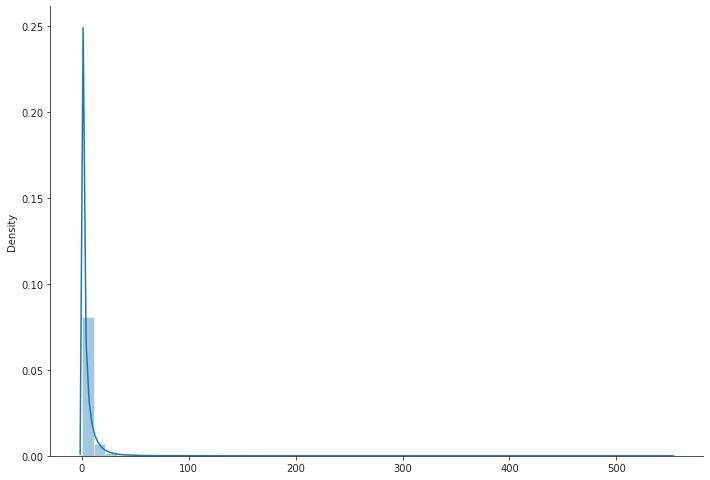

In [23]:
sns.set_style("ticks")
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
fig.set_size_inches(11.7,8.27)
sns.distplot(indegree_list)
sns.despine()
plt.show()

##### 1.2 number of people for each user is following
<pre> lets do eda on following, how the trend look like </pre>

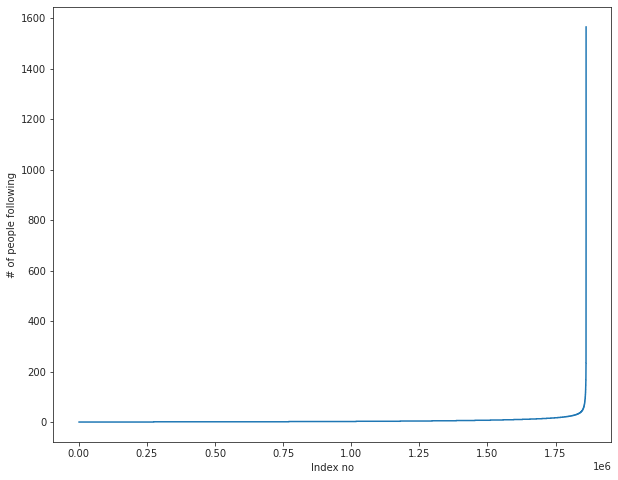

In [24]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,8))
plt.plot(outdegree_dist)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Index no')
plt.ylabel('# of people following')
plt.show()
# Same trend is follwing with with out degree.

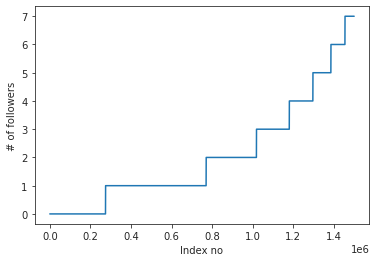

In [25]:
plt.plot(outdegree_dist[:1500000])
# plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Index no')
plt.ylabel('# of followers')
plt.show()

In [26]:
# lets see percentiles
for i in range(0,11):
  print(90+i,'percentile value is ',np.percentile(outdegree_dist,90+i))

# looks like, 99 percentile is 40 and 100th percentile is 1566, few users are following more than 40 people

90 percentile value is  12.0
91 percentile value is  13.0
92 percentile value is  14.0
93 percentile value is  15.0
94 percentile value is  17.0
95 percentile value is  19.0
96 percentile value is  21.0
97 percentile value is  24.0
98 percentile value is  29.0
99 percentile value is  40.0
100 percentile value is  1566.0


In [27]:
# lets see percentiles
for i in range(1,11):
  print(99+(i/10),'percentile value is ',np.percentile(outdegree_dist,99+(i/10)))

# looks like, 99.9 percentile is 123 and 100th percentile is 1566, only few users are following other people

99.1 percentile value is  42.0
99.2 percentile value is  45.0
99.3 percentile value is  48.0
99.4 percentile value is  52.0
99.5 percentile value is  56.0
99.6 percentile value is  63.0
99.7 percentile value is  73.0
99.8 percentile value is  90.0
99.9 percentile value is  123.0
100.0 percentile value is  1566.0


In [28]:
print(" Number of people who are not following any one are ",sum(np.array(outdegree_dist)==0),"which is",(sum(np.array(outdegree_dist)==0)*100)/len(outdegree_dist),'%')

 Number of people who are not following any one are  274512 which is 14.741115442858524 %


In [29]:
print(" Number of people having zero followers are",sum(np.array(indegree_list)==0), "which is of",(sum(np.array(indegree_list)==0)*100)/len(outdegree_dist),'%' )

 Number of people having zero followers are 188043 which is of 10.097786512871734 %


##### 1.2 Indegree + outdegree
<pre> lets do eda on following, how the trend look like </pre>

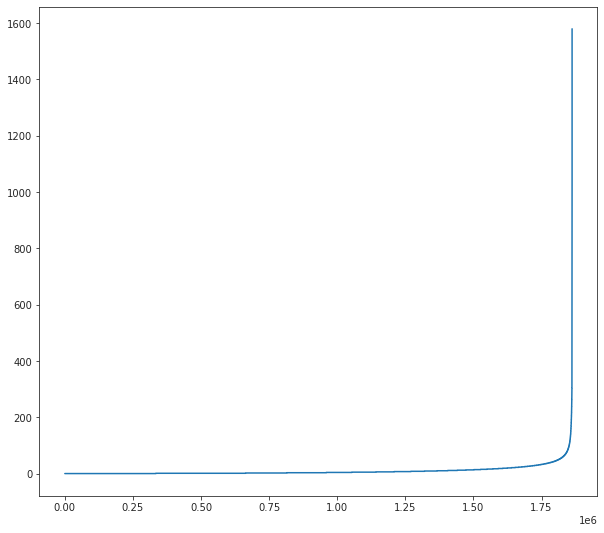

In [30]:
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d= Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))


in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,9))
plt.plot(in_out_degree_sort)
plt.show()
# Same trend appear here too

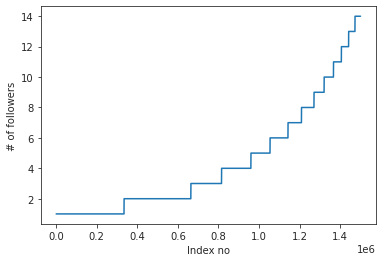

In [31]:
plt.plot(in_out_degree_sort[:1500000])
# plt.ticklabel_format(useOffset=False)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Index no')
plt.ylabel('# of followers')
plt.show()

In [32]:
# lets see percentiles
for i in range(0,11):
  print(90+i,'percentile value is ',np.percentile(in_out_degree_sort,90+i))

# looks like, 99 percentile is 40 and 100th percentile is 1566, few users are following more than 40 people

90 percentile value is  24.0
91 percentile value is  26.0
92 percentile value is  28.0
93 percentile value is  31.0
94 percentile value is  33.0
95 percentile value is  37.0
96 percentile value is  41.0
97 percentile value is  48.0
98 percentile value is  58.0
99 percentile value is  79.0
100 percentile value is  1579.0


In [33]:
# lets see percentiles
for i in range(1,11):
  print(99+(i/10),'percentile value is ',np.percentile(in_out_degree_sort,99+(i/10)))

# looks like, 99.9 percentile is 123 and 100th percentile is 1566, only few users are following other people

99.1 percentile value is  83.0
99.2 percentile value is  87.0
99.3 percentile value is  93.0
99.4 percentile value is  99.0
99.5 percentile value is  108.0
99.6 percentile value is  120.0
99.7 percentile value is  138.0
99.8 percentile value is  168.0
99.9 percentile value is  221.0
100.0 percentile value is  1579.0


In [34]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [35]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [36]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [37]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


###### Posing this problem as binary classification task.
<pre>
1. we have main dataset where we have all nodes, where edge is available, lets call them as 1.
2. we can derive nodes where in no edge is available, we can call them as 0.
3. so, it becomes a binary classification task.
4. from total graph, we have 1.86M nodes, and 9.43M edges. 
5. If we consider there are n nodes, there would have at max n-1 edges from that node. Then total edges becomes nx(n-1) edges.
6. As we have 1.86M nodes, then total edges could be 1.86Mx(1.86M-1) edges, which is a huge number of edges. All these edges we can call them as 0, by excepting already available edges.
7. As binary classification works better if we have balanced datasets, So, lets sample only 9.43M 0's from 6th point. So, in final dataset, we will be having 9.43M 1's and 9.43M 0's.
</pre>

In [38]:
!ls after_eda/

missing_edges_final.p	test_pos_after_eda.csv	 train_pos_after_eda.csv
test_after_eda.csv	train_after_eda.csv	 train_woheader.csv
test_neg_after_eda.csv	train_neg_after_eda.csv


In [39]:
%%time
r = csv.reader(open('after_eda/train_woheader.csv'))
edges = dict()
for edge in r:
  edges[(edge[0],edge[1])]=1
  # break

CPU times: user 7.12 s, sys: 910 ms, total: 8.03 s
Wall time: 8.04 s


In [40]:
# %%time
# missing_edges = set()
# while(len(missing_edges)<=9437519):
#   a = random.randint(1,1862220)
#   b = random.randint(1,1862220)
#   if edges.get((a,b),-1)==-1 and a!=b:
#     try:
#       if nx.shortest_path_length(g,source=a,target=b) >2:
#         missing_edges.add((a,b))
#       else:
#         continue
#     except:
#       missing_edges.add((a,b))
#   else:
#     missing_edges.add((a,b))

In [41]:
!ls

after_eda  fea_sample  test_y.csv  train.csv  train_y.csv


In [42]:
missing_edges = pickle.load(open('after_eda/missing_edges_final.p','rb'))

In [43]:
!ls

after_eda  fea_sample  test_y.csv  train.csv  train_y.csv


In [44]:
type(missing_edges)

set

In [55]:
# del missing_edges
del g

In [45]:
df_pos = pd.read_csv('train.csv')
df_neg = pd.DataFrame(list(missing_edges),columns=['source_edge','target_edge'])

In [46]:
print("Number of Nodes with edges in positive",df_pos.shape[0])
print("Number of nodes without edges in negative",df_neg.shape[0])

Number of Nodes with edges in positive 9437519
Number of nodes without edges in negative 9437519


In [47]:
x_train_pos,x_test_pos,y_train_pos,y_test_pos = train_test_split(df_pos,np.ones(9437519),test_size=0.20,random_state=9)
x_train_neg,x_test_neg,y_train_neg,y_test_neg = train_test_split(df_neg,np.zeros(9437519),test_size=0.20,random_state=9)

In [48]:
del traincsv

In [59]:
x_test_pos.head()

,source_node,destination_node
4303730,848424,784690
6328118,1248963,444518
1347397,264224,132395
2788658,549680,326829
4439018,875380,1394902


In [63]:
train_pos_graph=nx.from_pandas_edgelist(x_train_pos,source='source_node',target='destination_node',create_using=nx.DiGraph)
test_pos_graph = nx.from_pandas_edgelist(x_test_pos,source='source_node',target='destination_node',create_using=nx.DiGraph)

In [94]:
print(nx.info(train_pos_graph))
print('='*60)
print(nx.info(test_pos_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490


In [62]:
# del train_pos_graph,test_pos_graph
gc.collect()

299

In [93]:
# del edges
# del d
# del indegree_list,outdegree_dist,in_out_degree_sort,in_out_degree,dict_in,dict_out
# del test
gc.collect()

1033

In [92]:
local_vars,size_dict = list(globals().items()),dict()
for var, obj in local_vars:
  if var[0]!='_':
    size_dict[var]=sys.getsizeof(obj)/(1024*1024)
sorted(size_dict.items(),key=lambda x:x[1],reverse=True)

[('x_train_pos', 172.80615234375),
 ('x_train_neg', 172.80615234375),
 ('df_pos', 144.00525665283203),
 ('df_neg', 144.00525665283203),
 ('y_train_pos', 57.602134704589844),
 ('y_train_neg', 57.602134704589844),
 ('x_test_pos', 43.201560974121094),
 ('x_test_neg', 43.201560974121094),
 ('y_test_pos', 14.400604248046875),
 ('y_test_neg', 14.400604248046875),
 ('local_vars', 0.001495361328125),
 ('size_dict', 0.001129150390625),
 ('Counter', 0.001007080078125),
 ('In', 0.0008697509765625),
 ('Out', 0.00061798095703125),
 ('obj', 0.00024318695068359375),
 ('s', 0.0002288818359375),
 ('i', 0.000213623046875),
 ('train_test_split', 0.00012969970703125),
 ('r', 0.0001068115234375),
 ('edge', 9.1552734375e-05),
 ('pd', 7.62939453125e-05),
 ('np', 7.62939453125e-05),
 ('nx', 7.62939453125e-05),
 ('plt', 7.62939453125e-05),
 ('sns', 7.62939453125e-05),
 ('csv', 7.62939453125e-05),
 ('random', 7.62939453125e-05),
 ('pickle', 7.62939453125e-05),
 ('drive', 7.62939453125e-05),
 ('gc', 7.6293945312